# RSA

## Setup

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from tqdm import tqdm
import seaborn as sns
from itertools import combinations
from src.tools import corr, corr2d

from joblib import Parallel, delayed

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, LeaveOneGroupOut

In [2]:
subj = 'subj003'
process = 'EEG_RSA'
run_pairwise = False
run_crowd_decoding = False
run_repetition_reliability = False
run_splithalf_reliability = False
run_fmri_rsa = False
run_sample_test = False

n_groups = 5

top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
rdm_path = f'{top_path}/data/interim/PairwiseDecoding/{subj}'
annotation_path = f'{top_path}/data/raw/annotations'
preproc_file = f'{top_path}/data/interim/SIdyads_EEG_pilot/{subj}/{subj}_preproc.mat'
figure_path = f'{top_path}/reports/figures/{process}'
out_path = f'{top_path}/data/interim/{process}'
fMRI_path = f'{top_path}/data/interim/fMRI_RSA'

Path(figure_path).mkdir(exist_ok=True, parents=True)
Path(out_path).mkdir(exist_ok=True, parents=True)

In [3]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
feature_order = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']
annotated_features = ['indoor', 'expanse', 'object_directedness', 
                 'agent_distance', 'facingness', 'joint_action', 
                 'communication', 'valence', 'arousal']

### Load data

In [4]:
df = pd.read_csv(f'{top_path}/data/interim/SIdyads_EEG_pilot/{subj}/{subj}_trials.csv.gz')

In [5]:
preproc = loadmat(preproc_file)
artifact_trials = preproc['idx_badtrial'].squeeze().astype('bool')

In [6]:
trial_files = f'{top_path}/data/raw/SIdyads_trials_pilot/{subj}/timingfiles/*.csv'
trials = []
for run, tf in enumerate(sorted(glob(trial_files))):
    t = pd.read_csv(tf)
    t['run'] = run
    t['run_file'] = tf
    trials.append(t)
trials = pd.concat(trials).reset_index(drop=True)
trials['artifact_trial'] = artifact_trials
n_orig_trials = len(trials)
print(f'original number of trials: {n_orig_trials}')
trials = trials[~trials.artifact_trial].reset_index(drop=True)
trials.reset_index(inplace=True)
trials.rename(columns={'index': 'trial'}, inplace=True)
print(f'number of trials after EEG preprocessing: {len(trials)}')
print(f'percent of trials removed: {np.round(((n_orig_trials - len(trials))/n_orig_trials)*100):.0f}%')
print()
trials.head()

original number of trials: 1925
number of trials after EEG preprocessing: 1694
percent of trials removed: 12%



,trial,video_name,condition,block,iti,onset_time,offset_time,duration,response,movie_path,run,run_file,artifact_trial
0,0,yt-1icEOZdgkVY_35.mp4,1,1,1.2,2.016111,2.518062,0.501951,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False
1,1,yt-cYECXplgRi4_15.mp4,1,1,1.3,3.716548,4.206679,0.490131,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False
2,2,yt-UZjgD-xTz9Q_310.mp4,1,1,1.3,5.516985,6.011039,0.494054,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False
3,3,yt-ix0bg7Lgyas_26.mp4,1,1,1.2,7.317525,7.805758,0.488232,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False
4,4,flickr-1-6-4-12557575164_3.mp4,1,1,1.3,9.018111,9.509143,0.491032,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False


In [7]:
df = pd.merge(df, trials[['trial', 'video_name', 'condition', 'response']], on='trial', how='left')
df.head()

,Fp1,Fz,F3,F7,FT9,FC5,FC1,C3,T7,CP5,...,AF8,AF4,F2,FCz,Cz,time,trial,video_name,condition,response
0,8.735472,5.686434,5.076590,-4.853312,-0.240429,-0.381919,0.504047,-5.343845,8.675847,-8.626750,...,-13.583336,3.880689,3.520135,-7.019694,4.913806,-0.200,0,yt-1icEOZdgkVY_35.mp4,1,0
1,3.365890,1.075138,2.512730,-2.589950,0.133958,1.052591,-1.132042,-3.723745,1.474630,-4.946261,...,-6.130056,0.482707,-0.201281,-3.263562,2.281834,-0.196,0,yt-1icEOZdgkVY_35.mp4,1,0
2,-1.116111,-3.210701,-0.316578,-0.781479,0.657650,1.624744,-2.955230,-2.722367,-3.233254,-1.945700,...,-0.241895,-2.157839,-3.655005,-0.110527,-0.398855,-0.192,0,yt-1icEOZdgkVY_35.mp4,1,0
3,-4.015397,-6.872233,-3.357682,0.409699,1.424536,0.936027,-4.962186,-2.603494,-4.376443,0.000440,...,2.796520,-3.735013,-6.546080,1.857717,-2.932722,-0.188,0,yt-1icEOZdgkVY_35.mp4,1,0
4,-5.154380,-9.722095,-6.372378,1.162589,2.390034,-0.925313,-7.003766,-3.229957,-1.863082,0.944320,...,2.552754,-4.316272,-8.676120,2.575327,-5.066891,-0.184,0,yt-1icEOZdgkVY_35.mp4,1,0


## Data Quality Check

### Decode crowd condition

Double check that we can decode the catch trials. This should be very easy to decode because the visual stimulus is very different and the participants are making a response on these trials. 

In [8]:
if run_crowd_decoding:
    crowd_df = df.groupby(['time', 'video_name']).mean().reset_index()

    # identify channel columns
    channels = crowd_df.drop(columns=['time', 'video_name', 'trial', 'condition', 'response']).columns

    # initialize pipe and kfold splitter
    cv = KFold(n_splits=10, shuffle=True, random_state=0)
    pipe = Pipeline([('scale', StandardScaler()), ('lr', LogisticRegression())])

    # decode condition at each time point
    results = []
    chance = None
    time_groups = crowd_df.groupby('time')
    for time, time_df in tqdm(time_groups):
        time_df.reset_index(inplace=True)
        X = time_df[channels].to_numpy()
        y = time_df.condition.to_numpy().astype('int')
        if chance is None:
            chance = np.sum(y) / len(y)
        scores = []
        for train_index, test_index in cv.split(X):
            pipe.fit(X[train_index], y[train_index])
            scores.append(pipe.score(X[test_index], y[test_index]))
        results.append([time, np.mean(scores)])
    results = pd.DataFrame(results, columns=['time', 'accuracy'])

    # Plot the results
    ymin, ymax = results.accuracy.min(), results.accuracy.max()
    _, ax = plt.subplots()
    sns.lineplot(x='time', y='accuracy', data=results, ax=ax)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Time (s)')
    ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
        colors='gray', linestyles='dashed', zorder=0)
    ax.hlines(y=chance, xmin=results.time.min(), xmax=results.time.max(),
        colors='gray', linestyles='solid', zorder=0)
    ax.set_xlim([results.time.min(), results.time.max()])
    ax.set_ylim([ymin, ymax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'{figure_path}/{subj}_crowd-decoding.png')

### Remove crowd videos

Now remove the crowd videos or any false alarm trials from all subsequent analyses.

In [9]:
catch_trials = np.invert(df.condition.to_numpy().astype('bool'))
response_trials = df.response.to_numpy().astype('bool')
trial_to_remove = catch_trials + response_trials
df_filtered = df[~trial_to_remove].reset_index(drop=True).drop(columns=['condition', 'response'])
# df_filtered.to_csv(f'{out_path}/{subj}_raw-filtered.csv', index=False)
df_filtered.head()

,Fp1,Fz,F3,F7,FT9,FC5,FC1,C3,T7,CP5,...,FT8,F6,AF8,AF4,F2,FCz,Cz,time,trial,video_name
0,8.735472,5.686434,5.076590,-4.853312,-0.240429,-0.381919,0.504047,-5.343845,8.675847,-8.626750,...,3.714020,2.337699,-13.583336,3.880689,3.520135,-7.019694,4.913806,-0.200,0,yt-1icEOZdgkVY_35.mp4
1,3.365890,1.075138,2.512730,-2.589950,0.133958,1.052591,-1.132042,-3.723745,1.474630,-4.946261,...,3.402654,0.410580,-6.130056,0.482707,-0.201281,-3.263562,2.281834,-0.196,0,yt-1icEOZdgkVY_35.mp4
2,-1.116111,-3.210701,-0.316578,-0.781479,0.657650,1.624744,-2.955230,-2.722367,-3.233254,-1.945700,...,3.426078,-1.227485,-0.241895,-2.157839,-3.655005,-0.110527,-0.398855,-0.192,0,yt-1icEOZdgkVY_35.mp4
3,-4.015397,-6.872233,-3.357682,0.409699,1.424536,0.936027,-4.962186,-2.603494,-4.376443,0.000440,...,3.813816,-2.460307,2.796520,-3.735013,-6.546080,1.857717,-2.932722,-0.188,0,yt-1icEOZdgkVY_35.mp4
4,-5.154380,-9.722095,-6.372378,1.162589,2.390034,-0.925313,-7.003766,-3.229957,-1.863082,0.944320,...,4.242001,-3.303415,2.552754,-4.316272,-8.676120,2.575327,-5.066891,-0.184,0,yt-1icEOZdgkVY_35.mp4


### Reliability

#### Split-half reliability
Calculate the reliability in roughly even splits of the data depending on the presentation order

In [10]:
df_filtered['repetition'] = df_filtered.groupby(['time', 'video_name']).cumcount() + 1
df_filtered['even'] = False
df_filtered.loc[(df_filtered.repetition % 2) == 0, 'even'] = True
df_split = df_filtered.groupby(['time', 'video_name', 'even']).mean().reset_index()
channels = df_split.drop(columns=['time','video_name', 'even', 'trial', 'repetition']).columns

In [11]:
if run_splithalf_reliability:
    results = []
    time_groups = df_split.groupby('time')
    for time, time_df in time_groups:
        even = time_df[time_df.even].sort_values('video_name')
        odd = time_df[~time_df.even].sort_values('video_name')
        rs = corr2d(even[channels].to_numpy(), odd[channels].to_numpy())
        results.append([time,] + list(rs))
    results = pd.DataFrame(results, columns=['time',] + channels.to_list())
    results = pd.melt(results, id_vars=['time'], value_vars=channels, var_name='channel', value_name='reliability')

In [12]:
if run_splithalf_reliability:
    ymin, ymax = results.reliability.min(), results.reliability.max()

    _, axes = plt.subplots(2, sharex=True)
    for i, ax in enumerate(axes):
        if i == 0:
            sns.lineplot(x='time', y='reliability', hue='channel',
                        data=results, ax=ax)
            ax.tick_params(axis='x', which='both', length=0)
        else:
            sns.lineplot(x='time', y='reliability',
                    data=results, ax=ax)
            ax.set_xlabel('Time (s)')
        ax.set_ylabel('Reliability (r)')
        ax.hlines(y=0, xmin=results.time.min(), xmax=results.time.max(),
            colors='gray', linestyles='solid', zorder=0)
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
            colors='gray', linestyles='dashed', zorder=0)
        ax.set_xlim([results.time.min(), results.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.legend([])
    plt.tight_layout()
    plt.savefig(f'{figure_path}/{subj}_reliability.png')

#### Repetition reliability

Determine whether there is a plateau in the reliability based on the number of repeitions

In [13]:
if run_repetition_reliability: 
    results = []
    min_repeats = df_filtered.groupby('video_name').repetition.max().min()
    time_groups = df_filtered.groupby('time')
    for time, time_df in tqdm(time_groups):
        time_df.set_index(['repetition', 'video_name'], inplace=True)
        for n_samples in range(2, min_repeats, 2):
            inds = np.random.choice(min_repeats, n_samples, replace=False) + 1
            inds = inds.reshape((2, -1))
            even = time_df.loc[inds[0]].reset_index().groupby('video_name').mean()
            odd = time_df.loc[inds[1]].reset_index().groupby('video_name').mean()
            rs = corr2d(even[channels].to_numpy(), odd[channels].to_numpy())
            results.append([time, n_samples] + list(rs))
    results = pd.DataFrame(results, columns=['time', 'n_samples'] + channels.to_list())
    results = pd.melt(results, id_vars=['time', 'n_samples'], value_vars=channels, var_name='channel', value_name='reliability')

    time_res_avg = results.groupby(['time', 'n_samples']).mean().reset_index()
    time_avg = time_res_avg.groupby('n_samples').mean().reset_index()
    time_avg['time_window'] = 'all_time'
    stim_time_avg = time_res_avg.loc[(time_res_avg.time > .1) & (time_res_avg.time < .6)].groupby('n_samples').mean().reset_index()
    stim_time_avg['time_window'] = 'stim_time'
    time_avg = pd.concat([time_avg, stim_time_avg])


    _, ax = plt.subplots()
    sns.lineplot(x='n_samples', y='reliability', hue='time_window',
                    data=time_avg, ax=ax, markers=True, dashes=False)
    plt.tight_layout()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(f'{figure_path}/{subj}_reliability-curve.png')

## EEG RDMs

### Pairwise decoding

In [14]:
def temporal_smoothing(df, grouping=['video1', 'video2'], precision=3):
    rolling_df = df.groupby(grouping).apply(lambda x: x.rolling(window=5, min_periods=2, step=2).mean())
    rolling_df = rolling_df.reset_index().dropna()
    rolling_df['time'] = rolling_df['time'].round(precision)
    return rolling_df

In [15]:
def divide_into_groups(arr, n_groups=5):
    n = len(arr)
    
    # Calculate the size of each group
    group_size = n // n_groups
    remainder = n % n_groups
    
    groups = []
    start_idx = 0
    
    for i in range(n_groups):
        end_idx = start_idx + group_size + (i < remainder)  # Add 1 if this group takes an extra element
        group = arr[start_idx:end_idx]
        groups.append(group)
        start_idx = end_idx  # Update the starting index for the next group
        
    return groups

In [16]:
def generate_pseudo(arr, n_groups=5):
    inds = np.arange(len(arr))
    np.random.shuffle(inds)
    groups = divide_into_groups(inds, n_groups)
    pseudo_arr = []
    for group in groups:
        pseudo_arr.append(arr[group].mean(axis=0))
    return np.array(pseudo_arr)

In [17]:
def fit_and_predict(video1_array, video2_array, n_groups):
    #regenerate to ensure that it is thread safe
    logo = LeaveOneGroupOut()
    pipe = Pipeline([('scale', StandardScaler()), ('lr', LogisticRegression())])

    #define X, y, and groups to loop through
    X = np.vstack([generate_pseudo(video1_array, n_groups),
                    generate_pseudo(video2_array, n_groups)])
    y = np.hstack([np.zeros((n_groups)), np.ones((n_groups))]).astype('int')
    groups = np.concatenate([np.arange(n_groups), np.arange(n_groups)])

    #fit and predict 
    y_pred = []
    y_true = []
    for train_index, test_index in logo.split(X, y, groups=groups):
        pipe.fit(X[train_index], y[train_index])
        y_pred.append(pipe.predict(X[test_index]))
        y_true.append(y[test_index])
        
    #Return the mean prediction acurracy over all groups
    return np.mean(np.array(y_pred) == np.array(y_true))

In [18]:
df_filtered.sort_values(['time', 'video_name'], inplace=True)
videos = df_filtered.video_name.unique()
videos_nCk = list(combinations(videos, 2))
out_file = f'{out_path}/{subj}_decoding-distance.csv'

if run_pairwise:
    results = []
    time_groups = df_filtered.groupby('time')
    for time, time_df in tqdm(time_groups, total=len(time_groups)):
        result_for_t = Parallel(n_jobs=-1)(
            delayed(fit_and_predict)(time_df.loc[time_df.video_name == video1, channels].to_numpy(),
                                     time_df.loc[time_df.video_name == video2, channels].to_numpy(),
                                     n_groups) for video1, video2 in videos_nCk
        )
        for accuracy, (video1, video2) in zip(result_for_t, videos_nCk):
            results.append([time, video1, video2, accuracy])
    results = pd.DataFrame(results, columns=['time', 'video1', 'video2', 'distance'])
    results.to_csv(out_file, index=False)
elif not run_pairwise and os.path.exists(out_file):
    results = pd.read_csv(out_file)
else:
    results = None

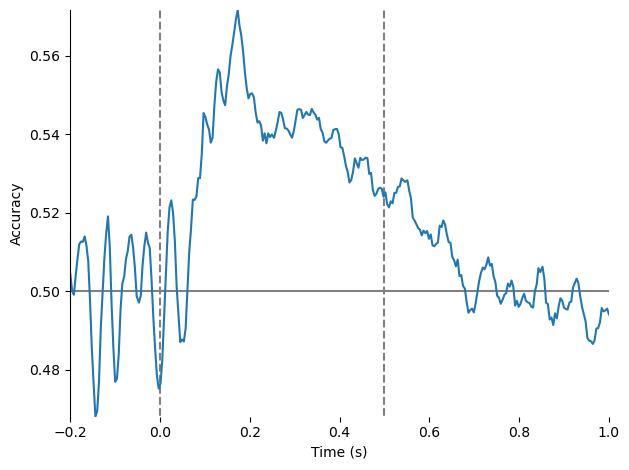

In [19]:
if results is not None:
    results.rename(columns={'accuracy': 'distance'}, inplace=True)
    avg_results = results.groupby('time').mean(numeric_only=True)
    ymin, ymax = avg_results.distance.min(), avg_results.distance.max()

    _, ax = plt.subplots()
    sns.lineplot(x='time', y='distance', data=avg_results, ax=ax)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Time (s)')
    ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
        colors='gray', linestyles='dashed', zorder=0)
    ax.hlines(y=.5, xmin=results.time.min(), xmax=results.time.max(),
        colors='gray', linestyles='solid', zorder=0)
    ax.set_xlim([results.time.min(), results.time.max()])
    ax.set_ylim([ymin, ymax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'{figure_path}/{subj}_decoding-distance.png')

Put the results in a dictionary for easy looping through different metrics

In [20]:
eeg_rdms = dict()
eeg_rdms['decoding'] = results

### Correlation distance

In [21]:
out_file = f'{out_path}/{subj}_correlation-distance.csv'
if os.path.exists(out_file):
    results = pd.read_csv(out_file)
else: 
    df_avg = df_filtered.groupby(['time', 'video_name']).mean(numeric_only=True).reset_index()
    df_avg.drop(columns=['trial', 'repetition', 'even'], inplace=True)
    df_avg.sort_values(['time', 'video_name'], inplace=True)
    videos = df_filtered.video_name.unique()
    videos_nCk = list(combinations(videos, 2))
    nCk = list(combinations(range(len(videos)), 2))

    results = []
    time_groups = df_avg.groupby('time')
    for time, time_df in tqdm(time_groups, total=len(time_groups)):
        rdm = pdist(time_df[channels].to_numpy(), metric='correlation')
        for i, (video1, video2) in enumerate(nCk):
            results.append([time, videos[video1], videos[video2],
                            rdm[i]])
    results = pd.DataFrame(results, columns=['time', 'video1', 'video2', 'distance'])
    results.to_csv(out_file, index=False)

Put the results in a dictionary for easy looping through different metrics

In [22]:
eeg_rdms['correlation'] = results

### Smooth RDMs

In [23]:
for EEG_metric in ['correlation', 'decoding']:
    if (EEG_metric in eeg_rdms.keys()) and (eeg_rdms[EEG_metric] is not None):
        eeg_rdms[EEG_metric] = temporal_smoothing(eeg_rdms[EEG_metric])

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_34972/3011165537.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['video1', 'video2'], dtype='object')
  rolling_df = df.groupby(grouping).apply(lambda x: x.rolling(window=5, min_periods=2, step=2).mean())
/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_34972/3011165537.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['video1', 'video2'], dtype='object')
  rolling_df = df.groupby(grouping).apply(lambda x: x.rolling(window=5, min_periods=2, step=2).mean())


## Feature RDMs

Load the feature annotations and make the RDMs. Care needs to be paid to ensure that that the order of the vidoes across the two RDMs is consistent. 

In [24]:
features_to_exclude = ['dominance', 'cooperation', 'intimacy']
df = pd.read_csv(f'{annotation_path}/annotations.csv')
# df = df.merge(pd.read_csv(f'{annotation_path}/test.csv'), on='video_name').set_index('video_name')
df = df.drop(columns=features_to_exclude)
rename = {col: col.replace(' ', '_') for col in df.columns}
rename['transitivity'] = 'object_directedness'
df.rename(columns=rename, inplace=True)
df.sort_index(inplace=True)

alexnet = pd.read_csv(f'{top_path}/data/interim/ActivationPCA/alexnet_PCs.csv').drop(columns=['split'])
df = df.merge(alexnet, on='video_name')

moten = pd.read_csv(f'{top_path}/data/interim/ActivationPCA/moten_PCs.csv').drop(columns=['split'])
df = df.merge(moten, on='video_name')

df.head()

,video_name,indoor,expanse,object_directedness,agent_distance,facingness,joint_action,communication,valence,arousal,...,alexnet_PC13,alexnet_PC14,alexnet_PC15,alexnet_PC16,alexnet_PC17,alexnet_PC18,alexnet_PC19,moten_PC0,moten_PC1,moten_PC2
0,-YwZOeyAQC8_15.mp4,1,0.225,0.895833,0.000000,0.045455,0.700000,0.550,0.650000,0.340909,...,-1.082823,10.191237,-22.614979,20.582584,20.926926,19.438461,14.355835,7.659730,21.567951,4.739616
1,1AIVH5cEWrI_35.mp4,1,0.250,0.104167,0.075000,1.000000,0.825000,0.900,0.675000,0.340909,...,258.609620,-38.368233,-33.512670,58.147423,40.795100,-20.262676,-65.375340,-14.666296,-13.239152,3.911069
2,2-8-0-2-5-4-8-8-5028025488_7.mp4,1,0.275,1.000000,0.045455,0.050000,0.575000,0.500,0.675000,0.075000,...,30.271772,17.192259,-6.165896,4.899196,-7.362109,51.271584,2.212805,5.335573,3.574568,4.336222
3,3PJaYWt0cws_5.mp4,0,0.625,1.000000,0.725000,0.340909,0.022727,0.150,0.600000,0.400000,...,-0.361651,13.382875,18.030890,12.732855,2.805191,5.295271,7.270865,-8.642924,11.198228,-8.109102
4,7-5-1-0-3-6-9-8-3775103698_9.mp4,1,0.275,0.925000,0.275000,0.636364,0.750000,0.825,0.722222,0.125000,...,62.311256,10.069392,50.194890,-33.658016,-59.276447,-21.671180,58.144630,-10.635544,-2.401499,2.511829


In [25]:
video_set = df.video_name.unique()
videos_nCk = list(combinations(video_set, 2))
feature_rdms = []
for feature in tqdm(feature_order):
    if 'alexnet' == feature or 'moten' == feature:
        cols = [col for col in df.columns if feature in col]
        array = df[cols].to_numpy()
        distance_matrix = pdist(array, metric='correlation')
    else: 
        array = np.expand_dims(df[feature].to_numpy(), axis=1)
        distance_matrix = pdist(array, metric='euclidean')
        
    for idx, (video1, video2) in enumerate(videos_nCk):
        feature_rdms.append([video1, video2, feature, distance_matrix[idx]])
feature_rdms = pd.DataFrame(feature_rdms, columns=['video1', 'video2', 'feature', 'distance'])
feature_rdms.head()
    

100%|██████████| 11/11 [00:00<00:00, 22.95it/s]


,video1,video2,feature,distance
0,-YwZOeyAQC8_15.mp4,1AIVH5cEWrI_35.mp4,alexnet,1.120146
1,-YwZOeyAQC8_15.mp4,2-8-0-2-5-4-8-8-5028025488_7.mp4,alexnet,0.844553
2,-YwZOeyAQC8_15.mp4,3PJaYWt0cws_5.mp4,alexnet,1.233495
3,-YwZOeyAQC8_15.mp4,7-5-1-0-3-6-9-8-3775103698_9.mp4,alexnet,1.105170
4,-YwZOeyAQC8_15.mp4,8-6-0-3-9-6-6-0-19586039660_4.mp4,alexnet,0.478400


## RSA

### EEG - Feature RSA

In [26]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_feature_EEG_RSA(out_file, rsa, feature_order):
    feature_group = rsa.groupby('feature')
    _, axes = plt.subplots(int(np.ceil(len(feature_order)/3)), 3,
                        figsize=(10,8),
                        sharey=True, constrained_layout=True)
    axes = axes.flatten()
    trim_axs(axes, len(feature_order))
    ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
    for ax, (feature, time_corr) in zip(axes, feature_group):
        sns.lineplot(x='time', y='Spearman rho', data=time_corr, ax=ax)
        if feature in ['alexnet', 'expanse', 'facingness', 'valence']:
            ax.set_ylabel('Spearman rho')
        else:
            ax.set_ylabel('')
            
        if feature in ['communication', 'valence', 'arousal']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
            ax.tick_params(axis='x', which='both', length=0)
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=time_corr.time.min(), xmax=time_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([time_corr.time.min(), time_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(feature)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [27]:
def compute_feature_EEG_RSA(feature_rdms, eeg_rdms, out_file=None):
    feature_group = feature_rdms.groupby('feature')
    neural_group = eeg_rdms.groupby('time')
    rsa = []
    for feature, feature_rdm in feature_group:
        for time, time_rdm in neural_group:
            rho, _ = spearmanr(feature_rdm.distance, time_rdm.distance)
            rsa.append([feature, time, rho])
    rsa = pd.DataFrame(rsa, columns=['feature', 'time', 'Spearman rho'])
    cat_type = pd.CategoricalDtype(categories=feature_order, ordered=True)
    rsa['feature'] = rsa.feature.astype(cat_type)
    if out_file is not None: 
        rsa.to_csv(out_file)
    return rsa

In [28]:
def filter_pairs(df, video_set):
    out_df = df.loc[df['video1'].isin(video_set)]
    out_df = out_df.loc[out_df['video2'].isin(video_set)]
    return out_df

In [29]:
for EEG_metric in ['correlation', 'decoding']:
    if (EEG_metric in eeg_rdms.keys()) and (eeg_rdms[EEG_metric] is not None):
        filtered_df = filter_pairs(eeg_rdms[EEG_metric], video_set)
        valid_videos = np.unique(np.concatenate([filtered_df.video1.to_numpy(),
                                                  filtered_df.video2.to_numpy()]))
        filtered_feature_rdms = filter_pairs(feature_rdms, valid_videos)

        out_file = f'{out_path}/{subj}_feature_EEG-{EEG_metric}_rsa.csv'
        rsa = compute_feature_EEG_RSA(filtered_feature_rdms, filtered_df, out_file)

        out_figure = f'{figure_path}/{subj}_feature_EEG-{EEG_metric}_rsa.png'
        plot_feature_EEG_RSA(out_figure, rsa, feature_order)

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_34972/3390690465.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_34972/3390690465.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


### EEG - fMRI RSA

In [ ]:
def load_fMRI_RDMs(files):
    fmri_rdms = []
    for file in files:
        fr = pd.read_csv(file)
        fmri_subj_name = file.split('/')[-1].split('_')[0]
        fr['subj'] = fmri_subj_name
        fmri_rdms.append(fr)
    fmri_rdms = pd.concat(fmri_rdms)
    fmri_rdms = fmri_rdms.groupby(['roi', 'video1', 'video2']).mean(numeric_only=True).reset_index()
    fmri_rdms.sort_values(by=['roi', 'video1', 'video2'])
    return fmri_rdms

In [ ]:
def compute_fMRI_EEG_RSA(out_file, fmri_rdms, eeg_rdms):
    roi_group = fmri_rdms.groupby('roi')
    neural_group = eeg_rdms.groupby('time')
    rsa = []
    for roi, roi_rdm in tqdm(roi_group):
        for time, time_rdm in neural_group:
            rho, _ = spearmanr(roi_rdm.distance, time_rdm.distance)
            rsa.append([roi, time, rho])
    rsa = pd.DataFrame(rsa, columns=['roi', 'time', 'Spearman rho'])
    cat_type = pd.CategoricalDtype(categories=rois, ordered=True)
    rsa['roi'] = rsa.roi.astype(cat_type)
    rsa.to_csv(out_file)
    return rsa

In [ ]:
def plot_fMRI_EEG_RSA(rsa, out_file):
    roi_group = rsa.groupby('roi')
    _, axes = plt.subplots(3, 3, sharey=True, sharex=True)
    axes = axes.flatten()
    ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
    for ax, (roi, roi_corr) in zip(axes, roi_group):
        sns.lineplot(x='time', y='Spearman rho', data=roi_corr, ax=ax)
        if roi in ['EVC', 'LOC', 'pSTS']:
            ax.set_ylabel('Spearman rho')
        else:
            ax.set_ylabel('')

        if roi in ['pSTS', 'face-pSTS', 'aSTS']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.tick_params(axis='x', which='both', length=0)

        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=roi_corr.time.min(), xmax=roi_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([roi_corr.time.min(), roi_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(roi)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [ ]:
if run_fmri_rsa:
    for fMRI_metric in ['correlation', 'decoding']:
        files = glob(f'{fMRI_path}/*set-test*{fMRI_metric}-distance.csv')
        fmri_rdms = load_fMRI_RDMs(files)

        for EEG_metric in ['correlation', 'decoding']:
            if eeg_rdms[EEG_metric] is not None:
                filtered_df = filter_pairs(eeg_rdms[EEG_metric], video_set)
                valid_videos = np.unique(np.concatenate([filtered_df.video1.to_numpy(),
                                                    filtered_df.video2.to_numpy()]))
                filtered_fmri_rdms = filter_pairs(fmri_rdms, valid_videos)

                out_file = f'{out_path}/{subj}_fMRI-{fMRI_metric}_EEG-{EEG_metric}_rsa.csv'
                rsa = compute_fMRI_EEG_RSA(out_file, filtered_fmri_rdms, filtered_df)

                out_figure = f'{figure_path}/{subj}_fMRI-{fMRI_metric}_EEG-{EEG_metric}_rsa.png'
                plot_fMRI_EEG_RSA(rsa, out_figure)


## Decoding

In [30]:
def plot_decoding(out_file, results, features, hue=None):
    feature_group = results.groupby('feature')
    _, axes = plt.subplots(int(np.ceil(len(features)/3)), 3,
                        figsize=(10,8),
                        sharey=True, constrained_layout=True)
    axes = axes.flatten()
    trim_axs(axes, len(features))
    ymin, ymax = results['r'].min(), results['r'].max()
    for ax, (feature, time_corr) in zip(axes, feature_group):
        sns.lineplot(x='time', y='r', data=time_corr, ax=ax, hue=hue)
        if feature in ['indoor', 'agent_distance', 'communication']:
            ax.set_ylabel('Prediction (r)')
        else:
            ax.set_ylabel('')
            
        if feature in ['communication', 'valence', 'arousal']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
            ax.tick_params(axis='x', which='both', length=0)
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=time_corr.time.min(), xmax=time_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([time_corr.time.min(), time_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(feature)
        if hue is not None:
            if feature == 'arousal':
                ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            else: 
                ax.legend_.remove()
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [31]:
def feature_decoding(neural_df, feature_df, annotated_features):
    # initialize pipe and kfold splitter
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    pipe = Pipeline([('scale', StandardScaler()), ('rr', Ridge())])

    results = []
    time_groups = neural_df.groupby('time')
    for time, time_df in time_groups:
        X = time_df[channels].to_numpy()
        for feature in annotated_features: 
            y = feature_df[feature].to_numpy()

            y_pred = []
            y_true = []
            for train_index, test_index in cv.split(X):
                pipe.fit(X[train_index], y[train_index])
                y_pred.append(pipe.predict(X[test_index]))
                y_true.append(y[test_index])
            r = corr(np.concatenate(y_pred), np.concatenate(y_true))
            results.append([time, feature, r])

    results = pd.DataFrame(results, columns=['time', 'feature', 'r'])

    cat_type = pd.CategoricalDtype(categories=annotated_features, ordered=True)
    results['feature'] = results.feature.astype(cat_type)

    return results

In [32]:
feature_df = df[['video_name',] + annotated_features]
videos = np.array(feature_df['video_name'])

df_avg = df_filtered.groupby(['time', 'video_name']).mean(numeric_only=True).reset_index()
df_avg.drop(columns=['trial', 'repetition', 'even'], inplace=True)
df_avg.sort_values(['time', 'video_name'], inplace=True)
df_avg = temporal_smoothing(df_avg, 'video_name')

results = []
for n_samples in tqdm(range(50, 250+1, 50), total=len(list(range(50, 250+1, 50)))):
    for n_perm in range(10):
        video_sample = np.random.choice(videos, n_samples, replace=False)
        sampling_feature_df = feature_df.loc[feature_df.video_name.isin(video_sample)]
        sampling_eeg_df = df_avg.loc[df_avg.video_name.isin(video_sample)] 

        interim_result = feature_decoding(sampling_eeg_df, sampling_feature_df,
                                          annotated_features)
        interim_result['n_sample'] = n_samples
        interim_result['n_perm'] = n_perm
        results.append(interim_result)
results = pd.concat(results)
results = results.groupby(['time', 'feature', 'n_sample']).mean().reset_index()
results.to_csv(f'{out_path}/{subj}_feature_EEG_decoding.png', index=False)

out_file = f'{figure_path}/{subj}_feature_EEG_decoding.png'
plot_decoding(out_file, results, annotated_features, hue='n_sample')

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_34972/3011165537.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['video_name'], dtype='object')
  rolling_df = df.groupby(grouping).apply(lambda x: x.rolling(window=5, min_periods=2, step=2).mean())
100%|██████████| 5/5 [11:25<00:00, 137.09s/it]
/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_34972/1015294435.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


## RSA Sample Test

In [ ]:
if run_sample_test: 
    import warnings
    from scipy.stats import ConstantInputWarning
    warnings.filterwarnings('ignore', category=ConstantInputWarning)

    min_repeats = df_filtered.groupby('video_name').repetition.max().min()
    df_stim = df_filtered.loc[(df_filtered.time > .1) & (df_filtered.time < 0.6)]
    indices = np.arange(min_repeats)

    rsa_sample = []
    for n_videos in tqdm(range(10, len(video_set)+1, 2), total=int(len(video_set)/2)):
        video_sample = np.random.choice(video_set, n_videos, replace=False)

        nCk = list(combinations(range(len(video_sample)), 2))
        sampling_df = df_stim.loc[df_stim.video_name.isin(video_sample)]
        sampling_features = filter_pairs(feature_rdms, video_sample)

        for n_samples in range(1, min_repeats, 2): 
            sample_indices = np.random.choice(indices, n_samples, replace=False) + 1
            cur_sample_df = sampling_df.loc[sampling_df.repetition.isin(sample_indices)]

            cur_sample_df = cur_sample_df.groupby(['time', 'video_name']).mean(numeric_only=True).reset_index()
            cur_sample_df.sort_values(['time', 'video_name'], inplace=True)
            
            results = []
            time_groups = cur_sample_df.groupby('time')
            for time, time_df in time_groups:
                rdm = pdist(time_df[channels].to_numpy(), metric='correlation')
                for i, (video1, video2) in enumerate(nCk):
                    results.append([time, video_sample[video1], video_sample[video2],
                                    rdm[i]])
            sampling_results = pd.DataFrame(results, columns=['time', 'video1', 'video2', 'distance'])
            rsa = compute_feature_EEG_RSA(sampling_features, sampling_results)
            rsa['n_samples'] = n_samples
            rsa['n_videos'] = n_videos
            rsa_sample.append(rsa)
    rsa_sample = pd.concat(rsa_sample)

    feature_group = rsa_sample.groupby(['feature', 'n_samples', 'n_videos']).mean().reset_index().groupby('feature')
    _, axes = plt.subplots(int(np.ceil(len(feature_order)/3)), 3,
                        figsize=(10,8),
                        sharey=True, constrained_layout=True)
    axes = axes.flatten()
    trim_axs(axes, len(feature_order))
    for ax, (feature, time_corr) in zip(axes, feature_group):
        sns.scatterplot(x='n_videos', y='Spearman rho',
                        data=time_corr, hue='n_samples', ax=ax)
        if feature in ['alexnet', 'expanse', 'facingness', 'valence']:
            ax.set_ylabel('Mean rho [.1-.6s]')
        else:
            ax.set_ylabel('')
            
        if feature in ['communication', 'valence', 'arousal']:
            ax.set_xlabel('Number of Videos')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(feature)
        if feature == 'arousal':
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        else:
            ax.legend_.remove()
    plt.tight_layout()
    plt.savefig(f'{figure_path}/{subj}_EEG-correlation_samples.png')